#### Aug. 12, 2018 3pm

In [1]:
import numpy   as np
import pandas  as pd

import pickle
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


---

#### Function Definitions

In [2]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [3]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [4]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

In [5]:
def show_most_informative_features(vectorizer, clf, n=20):
    
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [6]:
def topWords(clf_model_nb, vectorFts, numFtrs=50):

    
    # Empirical log probability of features x_i, given a class y; P(x_i|y).

    ftr_logProb = clf_model_nb.feature_log_prob_
    ftr_logProb.shape

    # Smoothed empirical log probability for each class.
    class_logProb = clf_model_nb.class_log_prior_


    posterior_ratios = (ftr_logProb[1,:] - ftr_logProb[0,:] + class_logProb[1] - class_logProb[0])

    inds = np.argsort(posterior_ratios)[-1:-200:-1]

    # posterior_ratios[inds]

    print(np.array(vectorFts)[inds])

---
### Modified: 

In [7]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-14 11:48:36.931573-07:00


---

### Large Pickled Dataset



In [8]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 868 ms, sys: 500 ms, total: 1.37 s
Wall time: 1.37 s


In [9]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 88 ms, sys: 36 ms, total: 124 ms
Wall time: 126 ms


In [10]:
# X_df.info()

In [11]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 16.2 s, sys: 156 ms, total: 16.4 s
Wall time: 16.4 s


In [12]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 692 ms, sys: 0 ns, total: 692 ms
Wall time: 690 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=62)

In [14]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [15]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
# 189
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
# 234
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])
# 357

In [16]:
vectorizer = CountVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [17]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 45.4 s, sys: 508 ms, total: 45.9 s
Wall time: 45.9 s


In [18]:
X_train_term.shape

(646101, 137644)

In [19]:
ftrs = vectorizer.get_feature_names()

In [20]:
len(vectorizer.get_stop_words())

357

---

#### Mutlinomial NB - Train

In [21]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [22]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 336 ms, sys: 52 ms, total: 388 ms
Wall time: 383 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [23]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 20.4 s, sys: 72 ms, total: 20.5 s
Wall time: 20.5 s


In [24]:
X_test_term.shape

(276901, 137644)

In [25]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 96 ms, sys: 16 ms, total: 112 ms
Wall time: 110 ms


In [26]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.90      0.91      0.91    220211
        1.0       0.65      0.61      0.63     56690

avg / total       0.85      0.85      0.85    276901



In [27]:
accuracy_score(y_test, pred)

precision_score(y_test, pred)

recall_score(y_test, pred)

f1_score(y_test, pred)

0.6275600826476239

Confusion matrix, without normalization


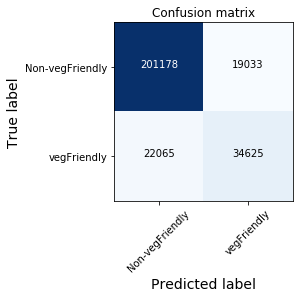

In [28]:
lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)

plot_confusion_matrix(cm,lbls)

# figName = 'MNB-CountVect-CMat'
# print("saving..." + figName)
# plt.gcf()
# plt.savefig(figName + '.png')
# plt.savefig(figName + '.pdf')

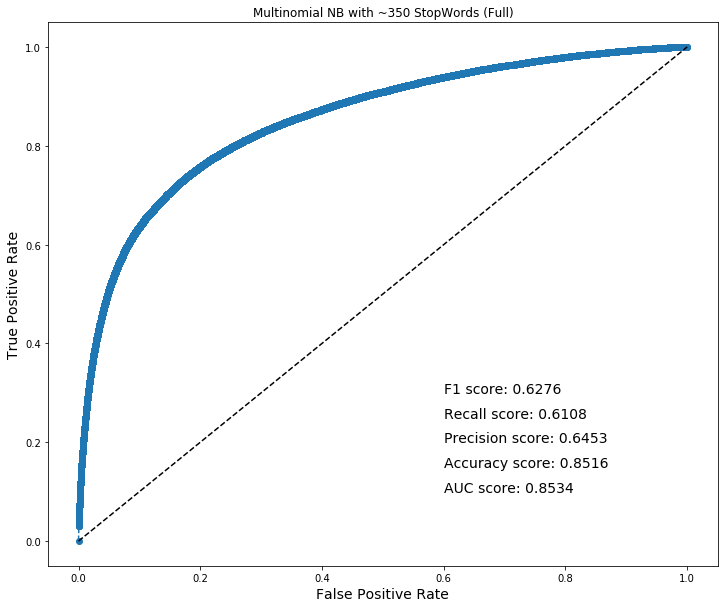

In [29]:
fTitle = 'Multinomial NB with ~350 StopWords (Full)'
mMetrics = True
fName = 'MNB_357StWds_full_countV'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

---

### Log odds of priors

In [30]:
show_most_informative_features(vectorizer, M_NB_model, 20)

	-15.7105	14             		-4.0107	food           
	-15.7105	TM             		-4.6553	great          
	-15.7105	aaaaaaahhhhhh  		-4.9457	service        
	-15.7105	aaaamaaazing   		-5.1159	one            
	-15.7105	aaaayway       		-5.1306	time           
	-15.7105	aakowa         		-5.1555	back           
	-15.7105	aalad          		-5.1945	go             
	-15.7105	aalmon         		-5.2389	chicken        
	-15.7105	aalo           		-5.2397	get            
	-15.7105	aalways        		-5.2947	would          
	-15.7105	aalyssa        		-5.3323	also           
	-15.7105	aamaaazing     		-5.3356	restaurant     
	-15.7105	aamaazingly    		-5.3512	delicious      
	-15.7105	aamco          		-5.4212	love           
	-15.7105	aamsotto       		-5.4334	menu           
	-15.7105	aamzing        		-5.4398	vegan          
	-15.7105	aandwiches     		-5.4578	try            
	-15.7105	aangekleed     		-5.5492	order          
	-15.7105	aangenaam      		-5.6044	got            
	-15.7105	aanji          		-5.6

---
### Ratio of posteriors for both classes

In [31]:
topWords(M_NB_model, ftrs, 50)

['injera' 'wac' 'vegenation' 'tsoynami' 'tsoynamis' 'lalibela' 'vegeway'
 'gomen' 'grabbagreen' 'soynami' 'lunasagna' 'chopt' 'nami' 'wellness'
 'brimstone' 'tfk' 'chakra' 'capastrami' 'tibs' 'eatt' 'brizza' 'pastoli'
 'alicha' 'misir' 'moko' 'chima' 'yayo' 'mijana' 'violette' 'doan' 'tlt'
 'thailicious' 'choolaah' 'tsom' 'taytu' 'cinnaholic' 'pitza' 'apteka'
 'dotty' 'ethiopian' 'zizi' 'grabba' 'doro' 'lgbtq' 'hussong' 'abay' 'ycs'
 'olivier' 'misoya' 'teff' 'yc' 'mvpita' 'yinzburgh' 'fosolia' 'quesas'
 'tikil' 'adda' 'wheatgrass' 'rvc' 'merkato' 'fern' 'fuegos' 'kome'
 'soynamis' 'graz' 'zoma' 'rawco' 'sambusas' 'mika' 'ipho' 'berbere'
 'aladdins' 'sega' 'braggs' 'chikn' 'panevino' 'buraka' 'sonio' 'ganoosh'
 'hemp' 'ikes' 'naji' 'kinoko' 'tofurky' 'treehouse' 'capistrami'
 'sprinly' 'nandini' 'sambussa' 'kitfo' 'jovany' 'nekter' 'gandhi'
 'kyklos' 'omnis' 'pastolis' 'greene' 'dumplinghaus' 'zenith' 'condesa'
 'angara' 'yalla' 'ethiopians' 'mestizo' 'maca' 'shawerma' 'dobra'
 'chopsh

---

### False Positives

Reviews for establishments that are not tagged as 'Veggie Friendly' but predicted that they are. 
-  It seems that the reviews here speak about the **food** more than about the establishment, which helps the model fish out establishments that are 'Veggie Friendly'.
-  **We were able to find Veggie-Freindly places without a tag.**

In [32]:
mask = y_test.index

# true flag (T/F): negative class
t_flag = y_test == 0

# predicted flag (T/F): positive class
p_flag = pred == 1

In [33]:
cX_test = X_test.copy()

In [34]:
cX_test.drop(['Thai', 'Italian', 'Indian', 'Chinese', 'Mexican', 'Text_length'], axis=1, inplace=True)

In [35]:
cX_test['prob'] = M_NB_model.predict_proba(X_test_term)[:,1]

In [36]:
cX_test.head()

,business_id,name,review_id,stars,date,text,useful,funny,cool,city,state,prob
583528,of4V8nfW7GwJ03tLDdrOlA,Barrio Cafe,AAgiaPli9LrGaR34Z6aDqA,1,2015-02-18,OK. At least get the food prep right!\n\nWhile...,5,1,4,Phoenix,AZ,1.364579e-04
479967,nUpz0YiBsOK7ff9k3vUJ3A,Buddy V's Ristorante,4lMlilpK-I0eOM6nXjdT5w,5,2017-01-22,Wow. This place is always great. The service i...,0,0,0,Las Vegas,NV,1.231998e-01
239772,Hqs4YNST_ZHbshwyi4bnsQ,Old School Pizzeria,omQEPFvy0Cq0NR7n76SQXw,1,2014-09-02,Really disappointed! We have been here before...,0,1,0,North Las Vegas,NV,3.007002e-13
365369,gotvSVEaPn_qHasAU33ejg,Ruchi Vegetarian South Indian Cuisine,44DXrsTM_OoqbJ1XdJFS5w,5,2016-08-29,Always good food and excellent personal servic...,0,0,0,Chandler,AZ,9.999195e-01
739002,t6ZIBNrQjvtwor8W-u3sUg,Chop Chop Wok,eR4js7q_FvTYNEsjcK4cXA,5,2017-02-04,"This place is amazing. It's not pricey at all,...",0,0,0,Las Vegas,NV,1.005816e-01


In [37]:
bus = cX_test.loc[p_flag & t_flag,['name', 'text', 'city', 'prob']].copy()

bus = bus.sort_values(by='prob', axis=0, ascending=False)

bus.head()

,name,text,city,prob
2378,Udipi Cafe,This has historically been my favorite restaur...,Monroeville,1.0
363761,Pastries N Chaat,This i believe is their fourth valley location...,Tempe,1.0
827601,India Palace,India Palace is the best Indian Restaurant to ...,Las Vegas,1.0
366697,Mount Everest India's Cuisine,My favorite Indian restaurant (Gaylord) is now...,Las Vegas,1.0
412820,Mount Everest India's Cuisine,When I saw Mt Everest getting ready to open I ...,Las Vegas,1.0


In [38]:
bus['text'].iloc[0]

"This has historically been my favorite restaurant in Pittsburgh. Unfortunately I eat a diet that isn't compatible with the carb-heavy S. Indian diet, but that doesn't change the fact that I will occasionally cheat and have a good meal here, and I will never stop praising it!\n\nThere is no 'atmosphere', unless you count the fact that it looks like your average restaurant in Chennai. It's clean, spartan diner booths, and up until a couple years ago didn't even use silverware (plastic forks and paper napkins in a cup at every table). But the food is what makes this restaurant amazing.\n\nMy favorite dish is the vegetable pullao, which is a mixture of rice and vegetables with spices served with raita. All of the dosas (big thin crepes) are wonderful, and it's difficult to choose a favorite-- you can't really go wrong. All of the chutneys are amazing, though the hari (green cilantro chutney) is the best in my opinion. The curries are good, too, but definitely not the strong point of the r

---

#### Prediction: my reviews

In [39]:
nr_rev ='the tacos were great the carne asada was very yummy and the cheese was\
very stringy. yum. would go back great tacos and cold beers'

vectorizer.transform([nr_rev])

M_NB_model.predict_proba(vectorizer.transform([nr_rev]))

array([[0.80626958, 0.19373042]])

In [40]:
nr_rev ='the masala was great very yummy indeed, i wish the naan was not cold but the paneer and garlic rice'

vectorizer.transform([nr_rev])

M_NB_model.predict_proba(vectorizer.transform([nr_rev]))

array([[0.05172995, 0.94827005]])

In [41]:
nr_rev ='the cheese pizza and garlic bread were bleh. wish the beer was colder and the service really sucked.\
i would say stay away not worth it did not taste fresh. even the salad was wilted'

vectorizer.transform([nr_rev])

M_NB_model.predict_proba(vectorizer.transform([nr_rev]))

array([[0.96240753, 0.03759247]])

---

### False Negative

Reviews for establishments that are Tagged as 'Veggie Friendly' but predicted as not being. 
-  It seems that the reviews here don't speak about the food, but more so about the establishment.

In [42]:
mask = y_test.index

# true flag (T/F): positive class
t_flag = y_test == 1

# predicted flag (T/F): negative class
p_flag = pred == 0

In [43]:
bus = cX_test.loc[p_flag & t_flag,['name', 'text', 'city', 'prob']].copy()

bus = bus.sort_values(by='prob', axis=0, ascending=False)
bus.head(10)

,name,text,city,prob
148482,Mellow Mushroom,"Beer seems very pricey, but they have a ton of...",Phoenix,0.499962
379390,Blanco Tacos + Tequila,Where do I start. Blanco tacos happy hour was ...,Scottsdale,0.499952
241922,Weera Thai Restaurant,Superb. Clean. The Take out containers are wor...,Las Vegas,0.499939
5966,Dhaba Indian Bistro,"Excellent food, best Indian in Madison that I'...",Middleton,0.499920
736572,Everly,This place rocked. They even gave us free arti...,Madison,0.499906
777147,True Food Kitchen,Cool place. Okay food. The chef needs to learn...,Phoenix,0.499750
596328,Spirit Organic Cafe,Went in and was ignored pretty much. If they h...,Gilbert,0.499682
554482,Urban Turban,"Wow, very tasty food. From a local, this place...",Las Vegas,0.499580
719753,Cafe Forte,This is an awesome restaurant in Downtown Scot...,Scottsdale,0.499540
137015,Joyride Taco House,Food is delicious and atmosphere is relaxed. T...,Phoenix,0.499520


In [44]:
bus['text'].iloc[0]

"Beer seems very pricey, but they have a ton of different kinds on tap.  \nThe food is absolutely excellent!  I love that they have baked wings.  The pizza my husband and I created (buffulo chicken, red sauce, and extra buffalo sauce) was awesome.  The crust is the best part, so if you're a person who usually skips that part, I highly recommend trying it!  It's got the perfect flavor with just a hint of sweetness to it.  It's really different from anything else I've had!"

In [45]:
bus['text'].iloc[1]

'Where do I start. Blanco tacos happy hour was exceptional. The chicken tacos were sensational. Those shrimp Po boy sandwiches......WOW! The bartender kept our shot glasses full. The drinks were top notch. I recommend any and everyone to check  out Blanco Tacos  for hip happening music and a really enjoy the great Mexican cuisine.'

In [46]:
bus['text'].iloc[7]

"Wow, very tasty food. From a local, this place use to be very busy, and though it's not now (sunday) sure is tasty and flavorful. I had level  spice and that was enough. Whew...hot but good.\n\nWill definitely come again."